### RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb)

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

#### Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [14]:
# %pip install devinterp matplotlib seaborn torchvision

### Run always

In [15]:
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

from joblib import Parallel, delayed

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# DEVICE = "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

In [26]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in (train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

from resnets import Net

In [17]:
# DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
# model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
# n_epochs = 40

60000


In [33]:
from devinterp.slt import estimate_learning_coeff

# Load MNIST data
MNIST_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=MNIST_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=MNIST_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
def rlct_estimate(model, num_chains=20):
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=num_chains,
        num_draws=200,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
        verbose=False,
    )
    rlct_estimate_sgld = None
    # estimate_learning_coeff(
    #     model,
    #     train_loader,
    #     criterion=criterion,
    #     optimizer_kwargs=dict(
    #         lr=1e-5,
    #         noise_level=1.0,
    #         elasticity=100.0,
    #         num_samples=len(train_data),
    #         temperature="adaptive",
    #     ),
    #     sampling_method=SGLD,
    #     num_chains=5,
    #     num_draws=400,
    #     num_burnin_steps=0,
    #     num_steps_bw_draws=1,
    #     device=DEVICE,
    #     verbose=False,
    # )

    print(rlct_estimate_sgld, rlct_estimate_sgnht)
    return rlct_estimate_sgnht, rlct_estimate_sgld

In [19]:
from tqdm import tqdm

def train_model_size(depth, n_epochs=20, lr=0.005, verbose=False):
    train_loss_trajectories = []
    test_loss_trajectories = []
    model = Net(depth=depth).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    
    if verbose:
        loop = tqdm(range(n_epochs))
    else:
        loop = range(n_epochs)
    
    for _ in loop:
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = evaluate(model, test_loader, criterion)
        train_loss_trajectories.append(train_loss)
        test_loss_trajectories.append(test_loss)
        # print(f"Model size {hidden_layer_size} Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    return model, train_loss_trajectories, test_loss_trajectories

### Test it for many models at convergence

In [20]:
depths = [2, 4, 6, 8, 12, 16]

In [21]:
# train_model_size(2, verbose=True)

In [28]:
# train multiple models of different sizes to convergence
# parallelize the training of different model sizes
n_epochs = 20
output = Parallel(n_jobs=4, verbose=10)(
    delayed(train_model_size)(depth, n_epochs) for depth in tqdm(depths)
)
models = [out[0] for out in output]
train_loss_trajectories = [out[1] for out in output]
test_loss_trajectories = [out[2] for out in output]

# set train/test losses as the last loss in the trajectory
train_losses = [train_loss_trajectory[-1] for train_loss_trajectory in train_loss_trajectories]
test_losses = [test_loss_trajectory[-1] for test_loss_trajectory in test_loss_trajectories]

100%|██████████| 5/5 [00:00<00:00, 264.20it/s]
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.4min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:  5.3min remaining:  3.5min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  7.4min finished


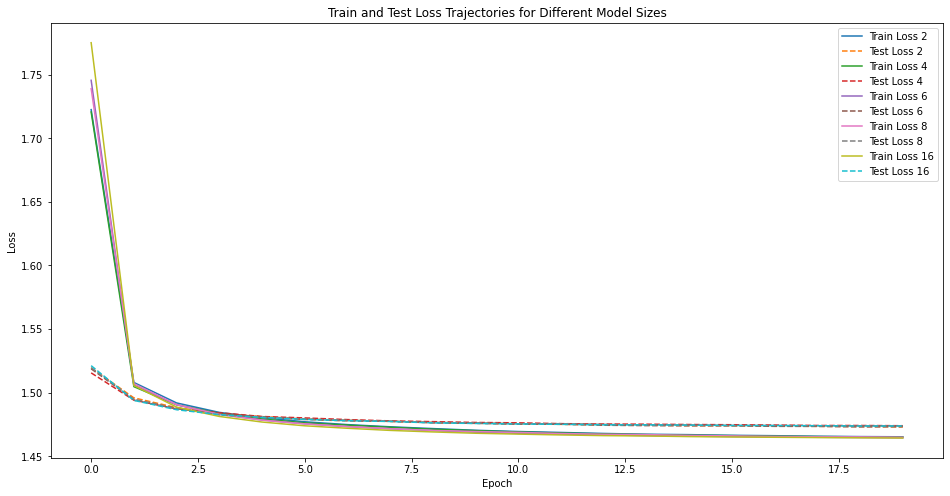

In [29]:
# plot train and test loss trajectories for different model sizes in different colors
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i, hidden_layer_size in enumerate(depths):
    ax.plot(train_loss_trajectories[i], label=f'Train Loss {hidden_layer_size}')
    ax.plot(test_loss_trajectories[i], linestyle='dashed', label=f'Test Loss {hidden_layer_size}')

ax.set_title('Train and Test Loss Trajectories for Different Model Sizes')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
# make figure larger
fig.set_size_inches(16, 8)
plt.show()

In [11]:
# DEVICE="cpu"

In [34]:
# parallelize the rlct method to populate rlct_estimates
rlct_estimates = Parallel(n_jobs=8, verbose=10)(delayed(rlct_estimate)(model) for model in tqdm(models))
# rlct_estimates = []
# for model in tqdm(models):
#     rlct_estimates.append(rlct_estimate(model))
rlct_estimates_sgnht = [rlct_estimate[0] for rlct_estimate in rlct_estimates]
rlct_estimates_sgld = [rlct_estimate[1] for rlct_estimate in rlct_estimates]

100%|██████████| 5/5 [00:00<00:00, 3980.17it/s]
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed: 13.3min remaining: 19.9min
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed: 13.9min remaining:  9.3min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed: 15.5min finished


In [31]:
def plot_rlct(train_losses, test_losses, rlct_estimates_sgnht, log_scale=False):
    sns.set_style("whitegrid")
    # plot rlct estimates
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("model size")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(depths, train_losses, label="Train Loss", color=PRIMARY)
    ax1.plot(depths, test_losses, label="Test Loss", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="lower left")

    ax2 = ax1.twinx()
    
    
    if log_scale:
        ax2.set_yscale("log")
        ax2.set_ylabel(r"Local Learning Coefficient, log($\hat \lambda$)", color=SECONDARY)
        ax2.plot(depths, rlct_estimates_sgnht, label="log($\lambda$)", color=SECONDARY)
    else: 
        ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
        ax2.plot(depths, rlct_estimates_sgnht, label="$\lambda$", color=SECONDARY)
    # ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")
    # fig.tight_layout()
    # make figure larger
    fig.set_size_inches(16, 8)
    # increase font size
    sns.set(font_scale=2)

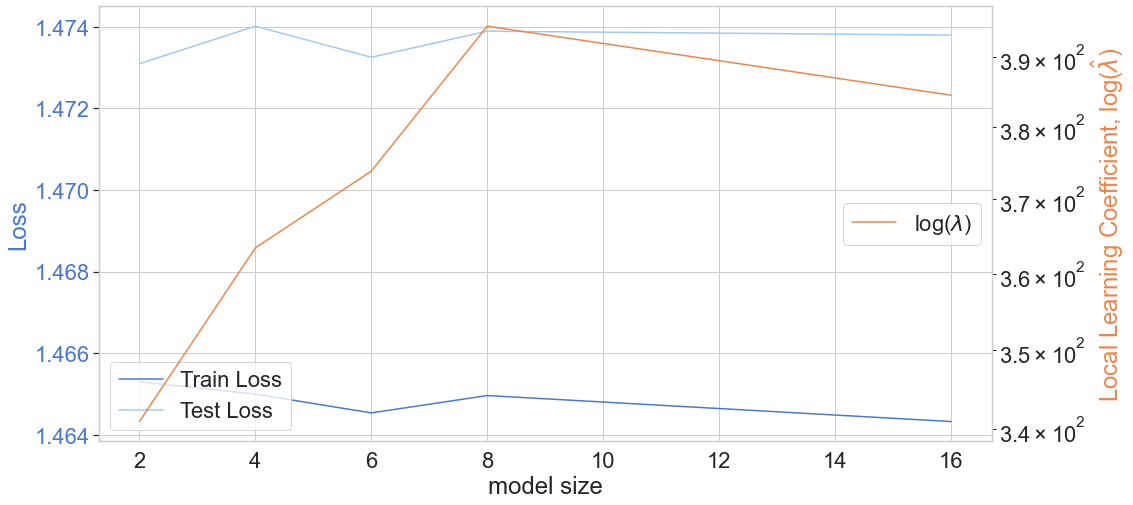

In [35]:
import numpy as np
plot_rlct(train_losses, test_losses, (rlct_estimates_sgnht), log_scale=True)

In [36]:
rlct_estimates_sgnht

[340.9067763432565,
 363.4405148366207,
 373.8659038602476,
 394.38470503522495,
 384.4779255118137]

### Same expt over multiple seeded runs

In [15]:
def plot_rlct(train_losses, test_losses, rlct_estimates_sgnht, depths):
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    # plot rlct estimates
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("model size")
    ax1.set_ylabel("Loss", color=PRIMARY)
    ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
    ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.legend(loc="lower left")

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    ax2.plot(rlct_estimates_sgnht, label="$\lambda$", color=SECONDARY)
    # ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")
    # make x ticks the model sizes
    ax2.set_xticks(range(len(depths)))
    ax2.set_xticklabels(depths)
    # make plot log scale
    # ax2.set_yscale("log")
    # fig.tight_layout()
    # make figure larger
    fig.set_size_inches(16, 8)
    # increase font size

training models: 100%|██████████| 4/4 [00:00<00:00, 8268.71it/s]00s/it]
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
averaging over 10 runs: 100%|██████████| 10/10 [23:04<00:00, 138.48s/it]


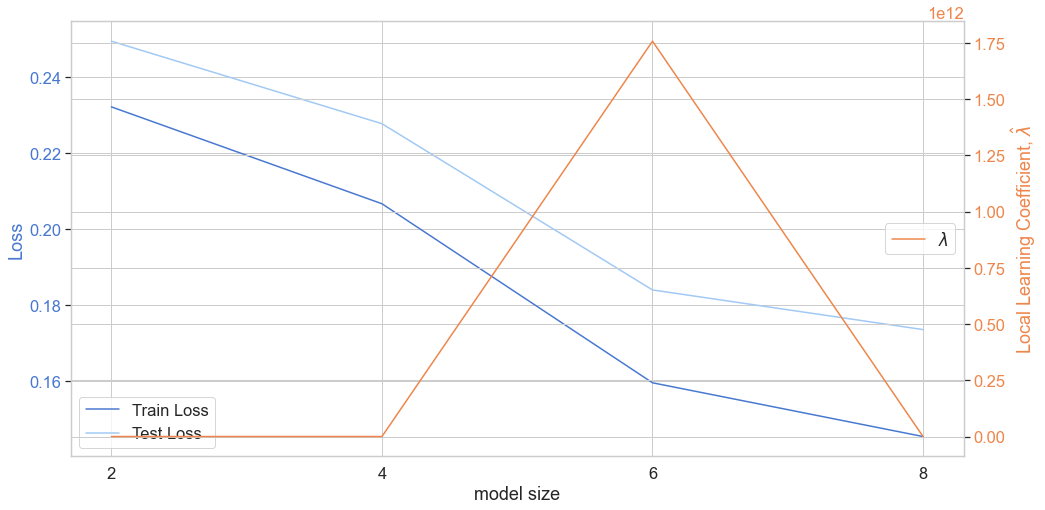

In [16]:
# average the above results over multiple runs
import numpy as np
n_runs = 10
seeds = np.arange(n_runs)
average_rlct_estimates_sgnht = np.zeros(len(depths))
average_rlct_estimates_sgld = np.zeros(len(depths))
variances_rlct_estimates_sgnht = np.zeros(len(depths))
variances_rlct_estimates_sgld = np.zeros(len(depths))
average_train_losses = np.zeros(len(depths))
average_test_losses = np.zeros(len(depths))

for i in tqdm(range(n_runs), desc=f"averaging over {n_runs} runs"):
    torch.manual_seed(i)
    # parallelize the training of different model sizes
    output = Parallel(n_jobs=4)(
        delayed(train_model_size)(hidden_layer_size) for hidden_layer_size in tqdm(depths, desc="training models")
    )
    models = [out[0] for out in output]
    train_loss_trajectories = [out[1] for out in output]
    test_loss_trajectories = [out[2] for out in output]
    
    rlct_estimates = Parallel(n_jobs=4)(delayed(rlct_estimate)(model) for model in tqdm(models, desc="estimating rlct"))
    rlct_estimates_sgnht = [rlct_estimate[0] for rlct_estimate in rlct_estimates]
    rlct_estimates_sgld = [rlct_estimate[1] for rlct_estimate in rlct_estimates]
    average_rlct_estimates_sgnht += rlct_estimates_sgnht
    average_rlct_estimates_sgld += rlct_estimates_sgld
    variances_rlct_estimates_sgnht += np.array(rlct_estimates_sgnht)**2
    variances_rlct_estimates_sgld += np.array(rlct_estimates_sgld)**2

    average_train_losses += np.array([train_loss_trajectory[-1] for train_loss_trajectory in train_loss_trajectories])
    average_test_losses += np.array([test_loss_trajectory[-1] for test_loss_trajectory in test_loss_trajectories])



average_rlct_estimates_sgnht /= n_runs
average_rlct_estimates_sgld /= n_runs
variances_rlct_estimates_sgld -= average_rlct_estimates_sgld**2
variances_rlct_estimates_sgnht -= average_rlct_estimates_sgnht**2
variances_rlct_estimates_sgld /= n_runs
variances_rlct_estimates_sgnht /= n_runs
average_test_losses /= n_runs
average_train_losses /= n_runs

plot_rlct(average_train_losses, average_test_losses, average_rlct_estimates_sgnht, depths)

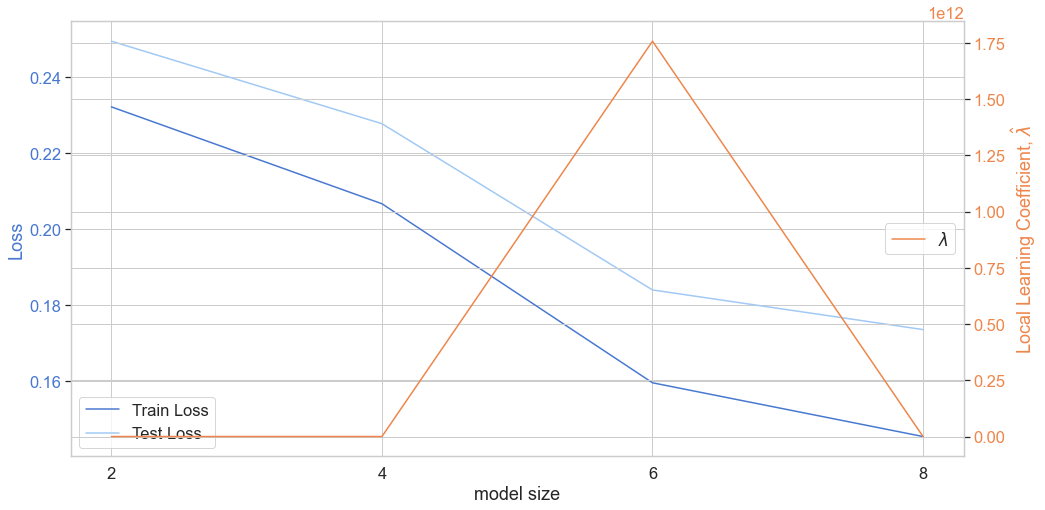

In [17]:
plot_rlct(average_train_losses, average_test_losses, average_rlct_estimates_sgnht, depths)

In [18]:
variances_rlct_estimates_sgld

array([ 140232.2178767 ,  308543.98286439, 2289965.50413226,
       2173850.6591233 ])

In [19]:
average_rlct_estimates_sgnht

array([4.62248355e+03, 9.13116875e+03, 1.75763369e+12, 1.44626557e+04])

In [20]:
1.3**(np.array(depths))

array([1.69      , 2.8561    , 4.826809  , 8.15730721])

In [21]:
# get parameter count for model
def get_paramer_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
np.array([get_paramer_count(model) for model in models])

array([7874, 7898, 7922, 7946])

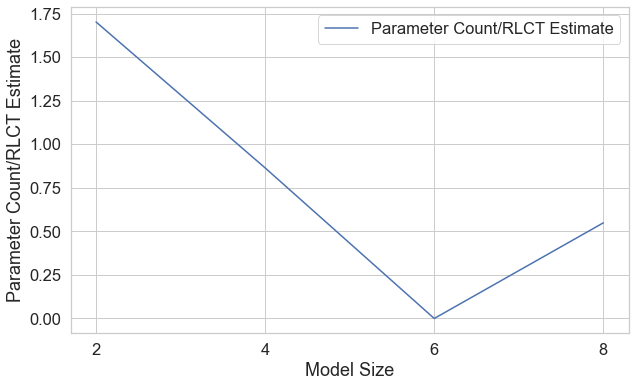

In [22]:
# plt.plot(average_rlct_estimates_sgnht, label="SGNHT")
plt.plot(np.array([get_paramer_count(model) for model in models])/average_rlct_estimates_sgnht, label="Parameter Count/RLCT Estimate")
plt.xlabel("Model Size")
plt.ylabel("Parameter Count/RLCT Estimate")
# x ticks
plt.xticks(range(len(depths)), depths)
plt.legend()
plt.gcf().set_size_inches(10, 6)

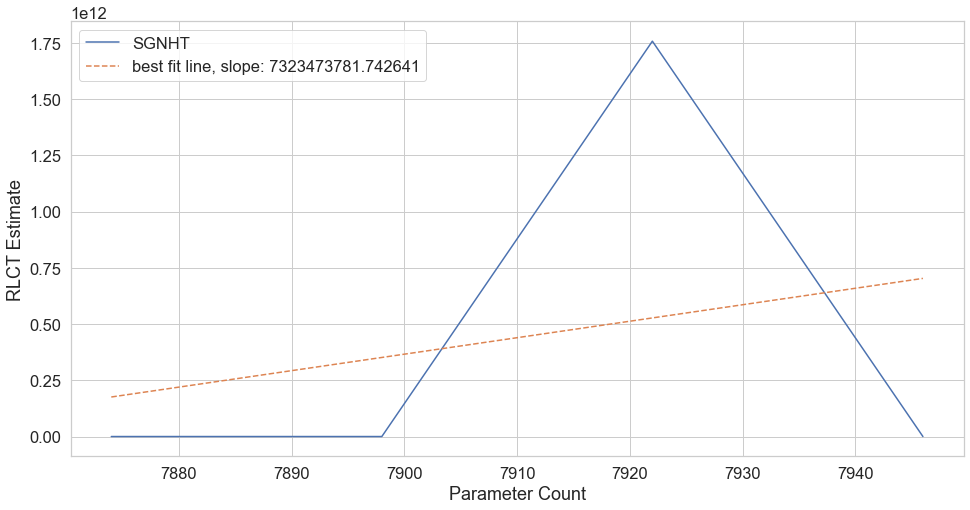

In [23]:
# plot average_rlct_estimates_sgnht vs parameter counts
x = np.array([get_paramer_count(model) for model in models])
plt.plot(x, average_rlct_estimates_sgnht, label="SGNHT")
# make figure larger
plt.gcf().set_size_inches(16, 8)
# plot best fit line
# x = np.array(depths).squeeze()
y = average_rlct_estimates_sgnht
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, label=f"best fit line, slope: {m}", linestyle='dashed')
plt.xlabel("Parameter Count")
plt.ylabel("RLCT Estimate")
plt.legend()

In [50]:
# plot average_rlct_estimates with error bars
import matplotlib.pyplot as plt

# Plot average_rlct_estimates with error bars
plt.errorbar(range(len(depths)), average_rlct_estimates_sgnht, yerr=np.sqrt(variances_rlct_estimates_sgnht), label='SGNHT')
# plt.errorbar(range(len(depths)), average_rlct_estimates_sgld, yerr=np.sqrt(variances_rlct_estimates_sgld), label='SGLD')

plt.xlabel('Model Size')
plt.ylabel('Average RLCT Estimate')
plt.title('Average RLCT Estimates with Error Bars')
plt.xticks(range(len(depths)), [str(size) for size in depths])
plt.legend()
# make figure larger
plt.gcf().set_size_inches(16, 8)
plt.show()

NameError: name 'average_rlct_estimates_sgnht' is not defined

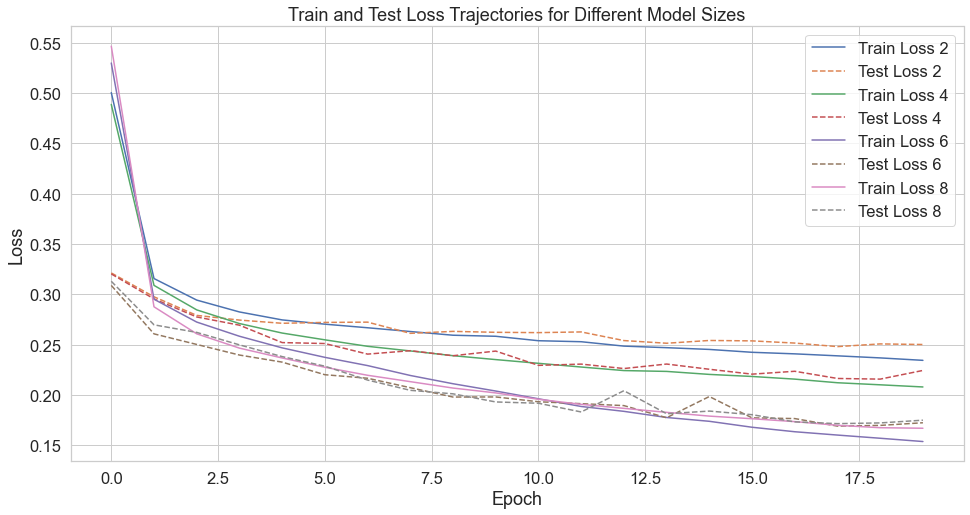

In [25]:
# plot train and test loss trajectories for different model sizes in different colors
fig, ax = plt.subplots()
# colors = ]
for i, hidden_layer_size in enumerate(depths):
    ax.plot(train_loss_trajectories[i], label=f'Train Loss {hidden_layer_size}')
    ax.plot(test_loss_trajectories[i], linestyle='dashed', label=f'Test Loss {hidden_layer_size}')

ax.set_title('Train and Test Loss Trajectories for Different Model Sizes')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
# make figure larger
fig.set_size_inches(16, 8)
plt.show()